# Regression in Python

***
This is a very quick run-through of some basic statistical concepts, adapted from [Lab 4 in Harvard's CS109](https://github.com/cs109/2015lab4) course. Please feel free to try the original lab if you're feeling ambitious :-) The CS109 git repository also has the solutions if you're stuck.

* Linear Regression Models
* Prediction using linear regression

Linear regression is used to model and predict continuous outcomes with normal random errors. There are nearly an infinite number of different types of regression models and each regression model is typically defined by the distribution of the prediction errors (called "residuals") of the type of data. Logistic regression is used to model binary outcomes whereas Poisson regression is used to predict counts. In this exercise, we'll see some examples of linear regression as well as Train-test splits.

The packages we'll cover are: `statsmodels`, `seaborn`, and `scikit-learn`. While we don't explicitly teach `statsmodels` and `seaborn` in the Springboard workshop, those are great libraries to know.
***

<img width=600 height=300 src="https://imgs.xkcd.com/comics/sustainable.png"/>
***

In [1]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns

# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression

# leverage plot
from statsmodels.graphics.regressionplots import plot_leverage_resid2

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

import matplotlib as mpl
# Set the default fontsize to 12
rcParams['font.size'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 12

***
# Part 1: Introduction to Linear Regression
### Purpose of linear regression
***
<div class="span5 alert alert-info">

<p> Given a dataset containing predictor variables $X$ and outcome/response variable $Y$, linear regression can be used to: </p>
<ul>
  <li> Build a <b>predictive model</b> to predict future values of $\hat{Y}$, using new data $X^*$ where $Y$ is unknown.</li>
  <li> Model the <b>strength of the relationship</b> between each independent variable $X_i$ and $Y$</li>
    <ul>
      <li> Many times, only a subset of independent variables $X_i$ will have a linear relationship with $Y$</li>
      <li> Need to figure out which $X_i$ contributes most information to predict $Y$ </li>
    </ul>
   <li>It is in many cases, the first pass prediction algorithm for continuous outcomes. </li>
</ul>
</div>

### A Brief Mathematical Recap
***

[Linear Regression](http://en.wikipedia.org/wiki/Linear_regression) is a method to model the relationship between a set of independent variables $X$ (also knowns as explanatory variables, features, predictors) and a dependent variable $Y$.  This method assumes the relationship between each predictor $X$ is **linearly** related to the dependent variable $Y$. The most basic linear regression model contains one independent variable $X$, we'll call this the simple model. 

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

where $\epsilon$ is considered as an unobservable random variable that adds noise to the linear relationship. In linear regression, $\epsilon$ is assumed to be normally distributed with a mean of 0. In other words, what this means is that on average, if we know $Y$, a roughly equal number of predictions $\hat{Y}$ will be above $Y$ and others will be below $Y$. That is, on average, the error is zero. The residuals, $\epsilon$ are also assumed to be "i.i.d.": independently and identically distributed. Independence means that the residuals are not correlated -- the residual from one prediction has no effect on the residual from another prediction. Correlated errors are common in time series analysis and spatial analyses.

* $\beta_0$ is the intercept of the linear model and represents the average of $Y$ when all independent variables $X$ are set to 0.

* $\beta_1$ is the slope of the line associated with the regression model and represents the average effect of a one-unit increase in $X$ on $Y$.

* Back to the simple model. The model in linear regression is the *conditional mean* of $Y$ given the values in $X$ is expressed a linear function.  

$$ y = f(x) = E(Y | X = x)$$ 

![conditional mean](images/conditionalmean.png)
http://www.learner.org/courses/againstallodds/about/glossary.html

* The goal is to estimate the coefficients (e.g. $\beta_0$ and $\beta_1$). We represent the estimates of the coefficients with a "hat" on top of the letter.  

$$ \hat{\beta}_0, \hat{\beta}_1 $$

* Once we estimate the coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$, we can use these to predict new values of $Y$ given new data $X$.

$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1$$

* Multiple linear regression is when you have more than one independent variable and the estimation involves matrices
    * $X_1$, $X_2$, $X_3$, $\ldots$


* How do you estimate the coefficients? 
    * There are many ways to fit a linear regression model
    * The method called **least squares** is the most common methods
    * We will discuss least squares

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 
    
### Estimating $\hat\beta$: Least squares
***
[Least squares](http://en.wikipedia.org/wiki/Least_squares) is a method that can estimate the coefficients of a linear model by minimizing the squared residuals: 

$$ \mathscr{L} = \sum_{i=1}^N \epsilon_i^2 = \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2  = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

where $N$ is the number of observations and $\epsilon$ represents a residual or error, ACTUAL - PREDICTED.  

#### Estimating the intercept $\hat{\beta_0}$ for the simple linear model

We want to minimize the squared residuals and solve for $\hat{\beta_0}$ so we take the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta_0}$ 

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_0}} &= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= -2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \hspace{25mm} \mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N (y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i) \\
&= -2 \left[ \left( \sum_{i=1}^N y_i \right) - N \hat{\beta_0} - \hat{\beta}_1 \left( \sum_{i=1}^N x_i
\right) \right] \\
& 2 \left[ N \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i \right] = 0 \hspace{20mm} \mbox{(Set equal to 0 and solve for $\hat{\beta}_0$)} \\
& N \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i = 0 \\
& N \hat{\beta}_0 = \sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i}{N} \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i}{N} - \hat{\beta}_1 \frac{\sum_{i=1}^N x_i}{N} \\
& \boxed{\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}}
\end{align}
$

Using this new information, we can compute the estimate for $\hat{\beta}_1$ by taking the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta}_1$.

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_1}} &= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= 2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \left( -x_i \right) \hspace{25mm}\mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N x_i \left( y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i \right) \\
&= -2 \sum_{i=1}^N x_i (y_i - \hat{\beta}_0 x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \sum_{i=1}^N x_i (y_i - \left( \bar{y} - \hat{\beta}_1 \bar{x} \right) x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \sum_{i=1}^N (x_i y_i - \bar{y}x_i + \hat{\beta}_1\bar{x}x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \left[ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i + \hat{\beta}_1\bar{x}\sum_{i=1}^N x_i - \hat{\beta}_1 \sum_{i=1}^N x_i^2 \right] \\
&= -2 \left[ \hat{\beta}_1 \left\{ \bar{x} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i^2 \right\} + \left\{ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i \right\}\right] \\
& 2 \left[ \hat{\beta}_1 \left\{ \sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i \right\} + \left\{ \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right\} \right] = 0 \\
& \hat{\beta}_1 = \frac{-\left( \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right)}{\sum_{i=1}^N x_i^2 - \bar{x}\sum_{i=1}^N x_i} \\
&= \frac{\sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i}{\sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i} \\
& \boxed{\hat{\beta}_1 = \frac{\sum_{i=1}^N x_i y_i - \bar{x}\bar{y}n}{\sum_{i=1}^N x_i^2 - n \bar{x}^2}}
\end{align}
$

The solution can be written in compact matrix notation as

$$\hat\beta =  (X^T X)^{-1}X^T Y$$ 

We wanted to show you this in case you remember linear algebra, in order for this solution to exist we need $X^T X$ to be invertible. Of course this requires a few extra assumptions, $X$ must be full rank so that $X^T X$ is invertible, etc. Basically, $X^T X$ is full rank if all rows and columns are linearly independent. This has a loose relationship to variables and observations being independent respective. **This is important for us because this means that having redundant features in our regression models will lead to poorly fitting (and unstable) models.** We'll see an implementation of this in the extra linear regression example.

***
# Part 2: Exploratory Data Analysis for Linear Relationships

The [Boston Housing data set](https://archive.ics.uci.edu/ml/datasets/Housing) contains information about the housing values in the suburbs of Boston. This dataset was originally taken from the StatLib library, which is maintained at Carnegie Mellon University and is now available on the UCI Machine Learning Repository. 

The machine learning community has developed awareness about fairness issues in the past couple of years with popular benchmarking datasets. The Boston Housing data has been phased out of many libraries (including scikit-learn). While this dataset will be removed in a future version of this mini-project, we ask students working through this exercise to pay close attention to how systemic racism can occur in data and sometimes be hard to spot.

We recommend that all students read this [excellent article](https://fairlearn.org/main/user_guide/datasets/boston_housing_data.html), which walks through the origin of the dataset and its flaws 
while discussing with their mentor the techniques suggested to avoid the disastrous consequences that might occur if not aware of the inherent racial bias in this dataset.



## Load the Boston Housing data set from `sklearn`
***

This data set is available in the [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston) python module which is how we will access it today.  

In [2]:
bos = pd.read_csv('boston-housing-dataset.csv').dropna()
bos.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Variables in order:

- **CRIM:** Per capita crime rate by town
- **ZN:** Proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS:** Proportion of non-retail business acres per town
- **CHAS:** Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- **NOX:** Nitric oxides concentration (parts per 10 million)
- **RM:** Average number of rooms per dwelling
- **AGE:** Proportion of owner-occupied units built prior to 1940
- **DIS:** Weighted distances to five Boston employment centers
- **RAD:** Index of accessibility to radial highways
- **TAX:** Full-value property-tax rate per \$10,000
- **PTRATIO:** Pupil-teacher ratio by town
- **B:** 1000(Bk - 0.63)^2 where Bk is the proportion of Blacks by town
- **LSTAT:** Percentage of lower-status population
- **MEDV:** Median value of owner-occupied homes in $1000's


Now we have a pandas DataFrame called `bos` containing all the data we want to use to predict Boston Housing prices.  Let's create a variable called `PRICE` which will contain the prices. This information is contained in the `target` data. 

In [3]:
print(bos.shape)

(394, 14)


In [4]:
# rename the target column to PRICE
bos.rename(columns={'MEDV': 'PRICE'}, inplace=True)
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


## EDA and Summary Statistics
***

Let's explore this data set.  First we use `describe()` to get basic summary statistics for each of the columns. 

In [5]:
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,3.690136,11.460660,11.000863,0.068528,0.553215,6.280015,68.932741,3.805268,9.403553,406.431472,18.537563,358.490939,12.769112,22.359645
std,9.202423,23.954082,6.908364,0.252971,0.113112,0.697985,27.888705,2.098571,8.633451,168.312419,2.166460,89.283295,7.308430,9.142979
min,0.006320,0.000000,0.460000,0.000000,0.389000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,2.600000,1.730000,5.000000
25%,0.081955,0.000000,5.130000,0.000000,0.453000,5.879250,45.475000,2.110100,4.000000,280.250000,17.400000,376.707500,7.125000,16.800000
50%,0.268880,0.000000,8.560000,0.000000,0.538000,6.201500,77.700000,3.199200,5.000000,330.000000,19.100000,392.190000,11.300000,21.050000
75%,3.435973,12.500000,18.100000,0.000000,0.624000,6.605500,94.250000,5.116700,24.000000,666.000000,20.200000,396.900000,17.117500,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Scatterplots
***

Let's look at some scatter plots for three variables: 'CRIM' (per capita crime rate), 'RM' (number of rooms) and 'PTRATIO' (pupil-to-teacher ratio in schools).  

Text(0.5, 1.0, 'Relationship between CRIM and Price')

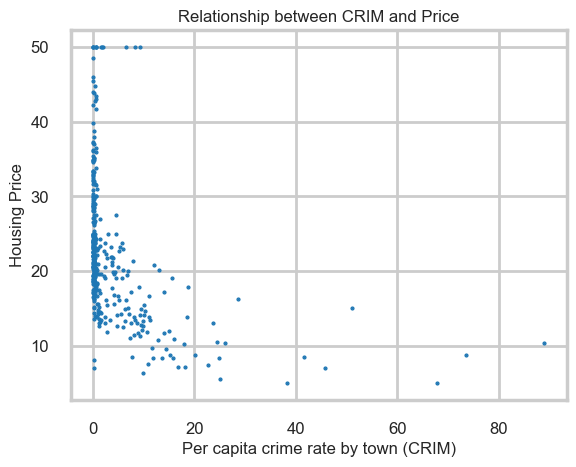

In [6]:
plt.scatter(bos.CRIM, bos.PRICE, s=1)
plt.xlabel("Per capita crime rate by town (CRIM)")
plt.ylabel("Housing Price")
plt.title("Relationship between CRIM and Price")

<div class="span5 alert alert-info">
<h3>Part 2 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> What kind of relationship do you see? e.g. positive, negative?  linear? non-linear? Is there anything else strange or interesting about the data? What about outliers?</p>


<p><b>Exercise:</b> Create scatter plots between *RM* and *PRICE*, and *PTRATIO* and *PRICE*. Label your axes appropriately using human readable labels. Tell a story about what you see.</p>

<p><b>Exercise:</b> What are some other numeric variables of interest? Why do you think they are interesting? Plot scatterplots with these variables and *PRICE* (house price) and tell a story about what you see.</p>

</div>

#### Exercise: describe relationship

- **Negative Relationship:** The relationship between the "PRICE" (housing price) and "CRIM" (per capita crime rate by town) columns in the Boston housing dataset appears to be negative. As the "CRIM" (crime rate) increases, the "PRICE" (housing price) tends to decrease, indicating that areas with higher crime rates tend to have lower housing prices.

- **Non-Linear:** While there is a negative trend, it doesn't seem to be a perfectly linear relationship. Instead, it's more non-linear, with variations in housing prices at different crime rate levels, suggesting the influence of other factors.

- **Outliers:** Some data points deviate from the general trend and can be considered outliers. These outliers may be due to various factors, such as location, amenities, or historical reasons.

- **Interesting Patterns:** There are clusters of data points within certain crime rate ranges, indicating that housing prices tend to cluster together within those specific ranges. This suggests the presence of other factors influencing housing prices within those ranges.

#### Exercise: scatter plot between *RM* and *PRICE*


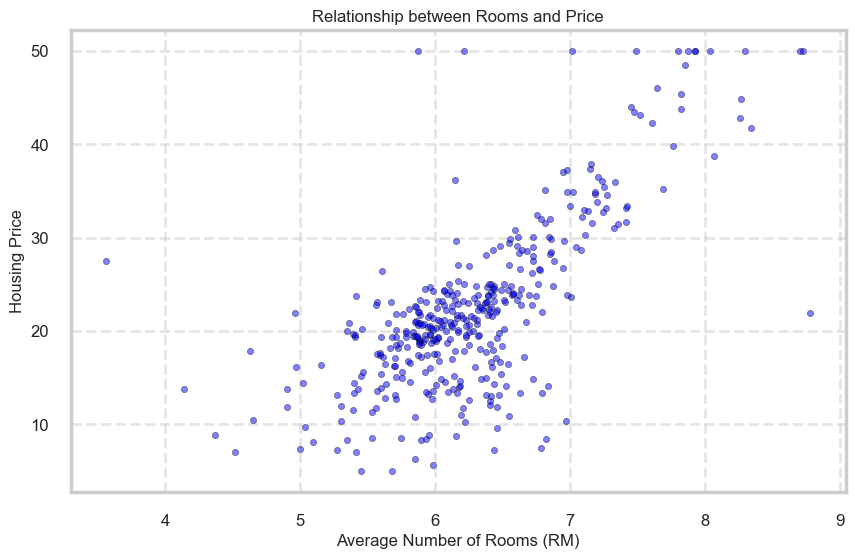

In [7]:
# RM <=> PRICE

plt.figure(figsize=(10, 6))
plt.scatter(bos.RM, bos.PRICE, s=20, alpha=0.5, c='b', marker='o', edgecolors='k', linewidths=0.5)
plt.xlabel("Average Number of Rooms (RM)")
plt.ylabel("Housing Price")
plt.title("Relationship between Rooms and Price")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In the scatterplot of the Boston housing dataset, depicting the "PRICE" (housing price) against the "RM" (average number of rooms per dwelling) column, a clear and positive relationship emerges. As the number of rooms per dwelling increases, housing prices tend to rise, indicating a straightforward positive correlation. This relationship follows a predominantly linear trend, with each additional room contributing to a consistent increase in housing prices. However, there are notable outliers, properties that deviate from this trend. Some houses with fewer rooms command high prices, while a few with more rooms have lower price tags, suggesting that other factors, such as location or unique features, influence pricing. This mix of linearity and outliers adds depth to the understanding of housing price dynamics in Boston.

#### Exercise: scatter plot between *PTRATIO* and *PRICE*


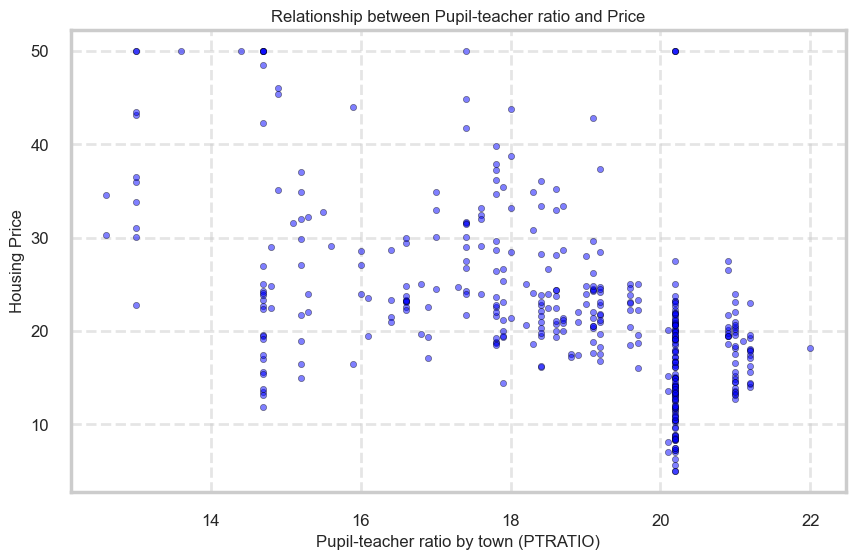

In [8]:
# PTRATIO <=> PRICE
plt.figure(figsize=(10, 6))
plt.scatter(bos.PTRATIO, bos.PRICE, s=20, alpha=0.5, c='b', marker='o', edgecolors='k', linewidths=0.5)
plt.xlabel("Pupil-teacher ratio by town (PTRATIO)")
plt.ylabel("Housing Price")
plt.title("Relationship between Pupil-teacher ratio and Price")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

There is a negative relationship, implying that as the pupil-teacher ratio increases, housing prices tend to decrease, suggesting a generally negative correlation. However, this relationship appears to be more non-linear than linear, with variations in housing prices across different pupil-teacher ratio levels. Notably, there are outliers in the data, where certain areas exhibit unexpected housing price patterns relative to their pupil-teacher ratios. Some regions with higher pupil-teacher ratios surprisingly have higher housing prices, while a few areas with lower ratios have lower prices. These outliers may be influenced by additional factors such as location, amenities, or unique characteristics of the neighborhoods.

#### Exercise: create some other scatter plots


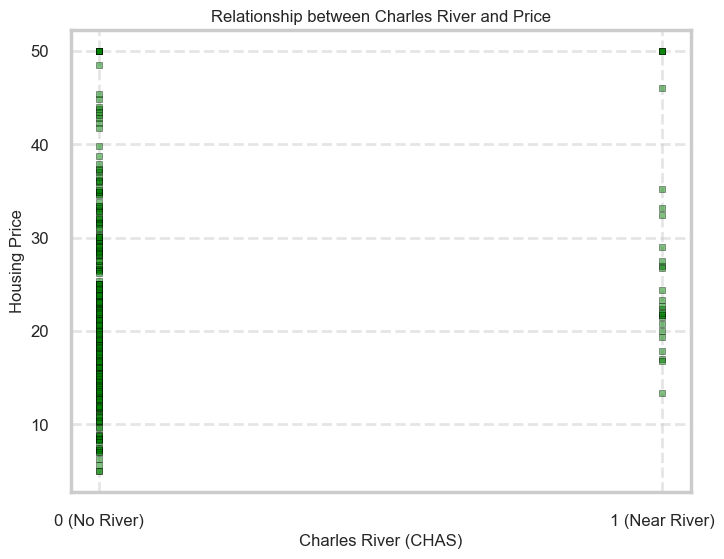

In [9]:
# CHAS <=> PRICE
plt.figure(figsize=(8, 6))
plt.scatter(bos.CHAS, bos.PRICE, s=20, alpha=0.5, c='g', marker='s', edgecolors='k', linewidths=0.5)
plt.xlabel("Charles River (CHAS)")
plt.ylabel("Housing Price")
plt.title("Relationship between Charles River and Price")
plt.xticks([0, 1], ['0 (No River)', '1 (Near River)'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Homes located near the Charles River ("1" on the x-axis) tend to have higher housing prices, while those away from the river ("0" on the x-axis) generally exhibit lower prices. This binary variable captures a notable divide in housing prices based on river proximity, suggesting that the presence of the Charles River has a significant positive impact on property values.

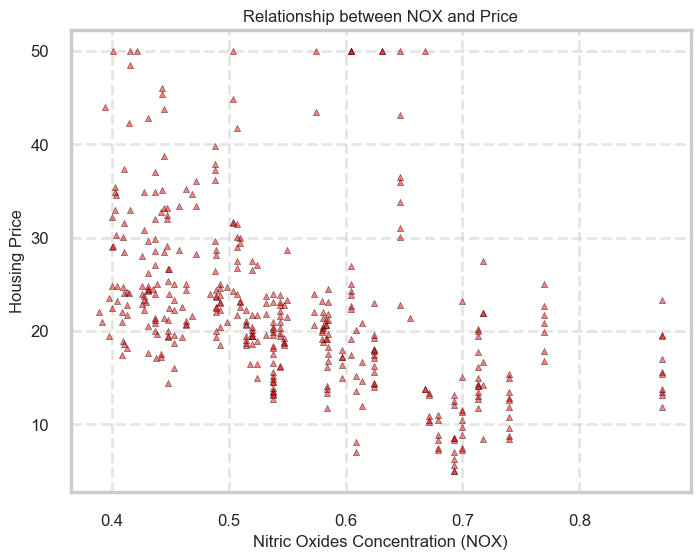

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(bos.NOX, bos.PRICE, s=20, alpha=0.5, c='r', marker='^', edgecolors='k', linewidths=0.5)
plt.xlabel("Nitric Oxides Concentration (NOX)")
plt.ylabel("Housing Price")
plt.title("Relationship between NOX and Price")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

As the concentration of nitric oxides increases, housing prices tend to decrease, indicating a clear negative correlation. This relationship suggests that areas with higher nitric oxide levels, potentially indicating poorer air quality, tend to have lower housing prices.

### Scatterplots using Seaborn
***

[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) is a cool Python plotting library built on top of matplotlib. It provides convenient syntax and shortcuts for many common types of plots, along with better-looking defaults.

We can also use [seaborn regplot](https://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html#functions-to-draw-linear-regression-models) for the scatterplot above. This provides automatic linear regression fits (useful for data exploration later on). Here's one example below.

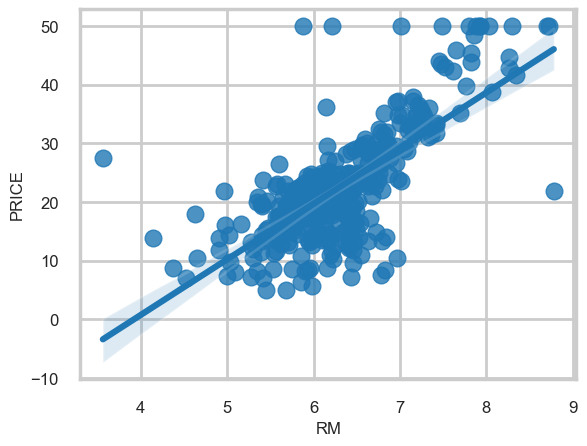

In [11]:
sns.regplot(y="PRICE", x="RM", data=bos, fit_reg = True);

### Histograms
***


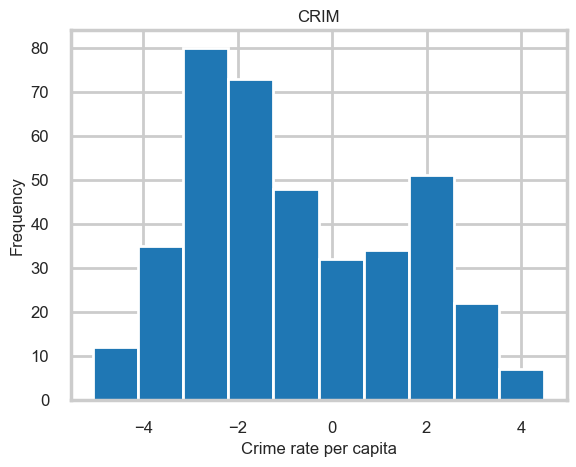

In [12]:
plt.hist(np.log(bos.CRIM))
plt.title("CRIM")
plt.xlabel("Crime rate per capita")
plt.ylabel("Frequency")
plt.show()

<div class="span5 alert alert-info">
<h3>Part 2 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> In the above histogram, we took the logarithm of the crime rate per capita. Repeat this histogram without taking the log. What was the purpose of taking the log? What do we gain by making this transformation? What do you now notice about this variable that is not obvious without making the transformation?

<p><b>Exercise:</b> Plot the histogram for *RM* and *PTRATIO* against each other, along with the two variables you picked in the previous section. We are looking for correlations in predictors here.</p>
</div>

### Excercise 1 of part 2

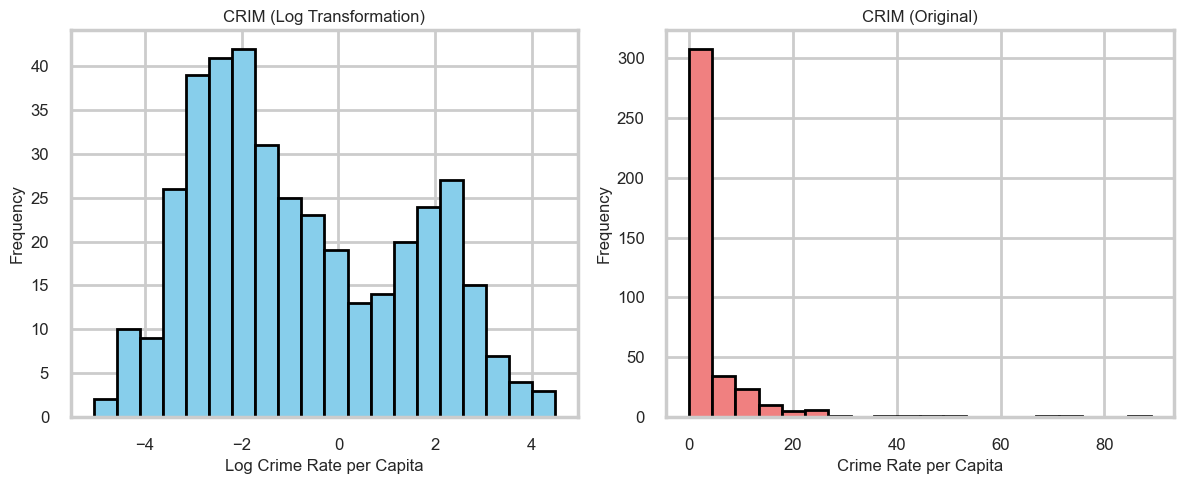

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# histogram with log transformation
axes[0].hist(np.log(bos.CRIM), bins=20, color='skyblue', edgecolor='k')
axes[0].set_title("CRIM (Log Transformation)")
axes[0].set_xlabel("Log Crime Rate per Capita")  # Adjust the font size here
axes[0].set_ylabel("Frequency")  # Adjust the font size here

# histogram without log transformation
axes[1].hist(bos.CRIM, bins=20, color='lightcoral', edgecolor='k')
axes[1].set_title("CRIM (Original)")
axes[1].set_xlabel("Crime Rate per Capita")
axes[1].set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout()

plt.show()

**Purpose of taking the log:**

Taking the logarithm is done to address the issue of skewed data. When a variable is highly skewed, it becomes difficult to visualize and analyze the data effectively. The log transformation is a common technique to reduce the impact of extreme values and make the data more symmetric and easier to work with.

**What we gain by making the transformation:**

By taking the logarithm, we compress the range of values, pulling in the extreme values closer to the central values. This results in a histogram that's less skewed and more symmetric. It allows us to see the distribution of "CRIM" more clearly and identify patterns or characteristics that might not be apparent in the original skewed data.

**What we notice about the variable:**

When we view the histogram without the log transformation, we typically see a highly skewed distribution with most data points clustered near the lower end of the scale. This can make it challenging to discern patterns or variations in the data, especially in the presence of extreme outliers. In contrast, after applying the log transformation, the histogram reveals a more symmetric distribution that may highlight subpopulations or patterns within the data that were not immediately evident in the original skewed representation. In essence, the log transformation helps to reveal hidden details and allows for more accurate analysis and modeling of the "CRIM" variable.


### Exercise 2 of part 2: 
Plot the histogram for *RM*, *PTRATIO*, *CHAS* and *NOX* against each other.

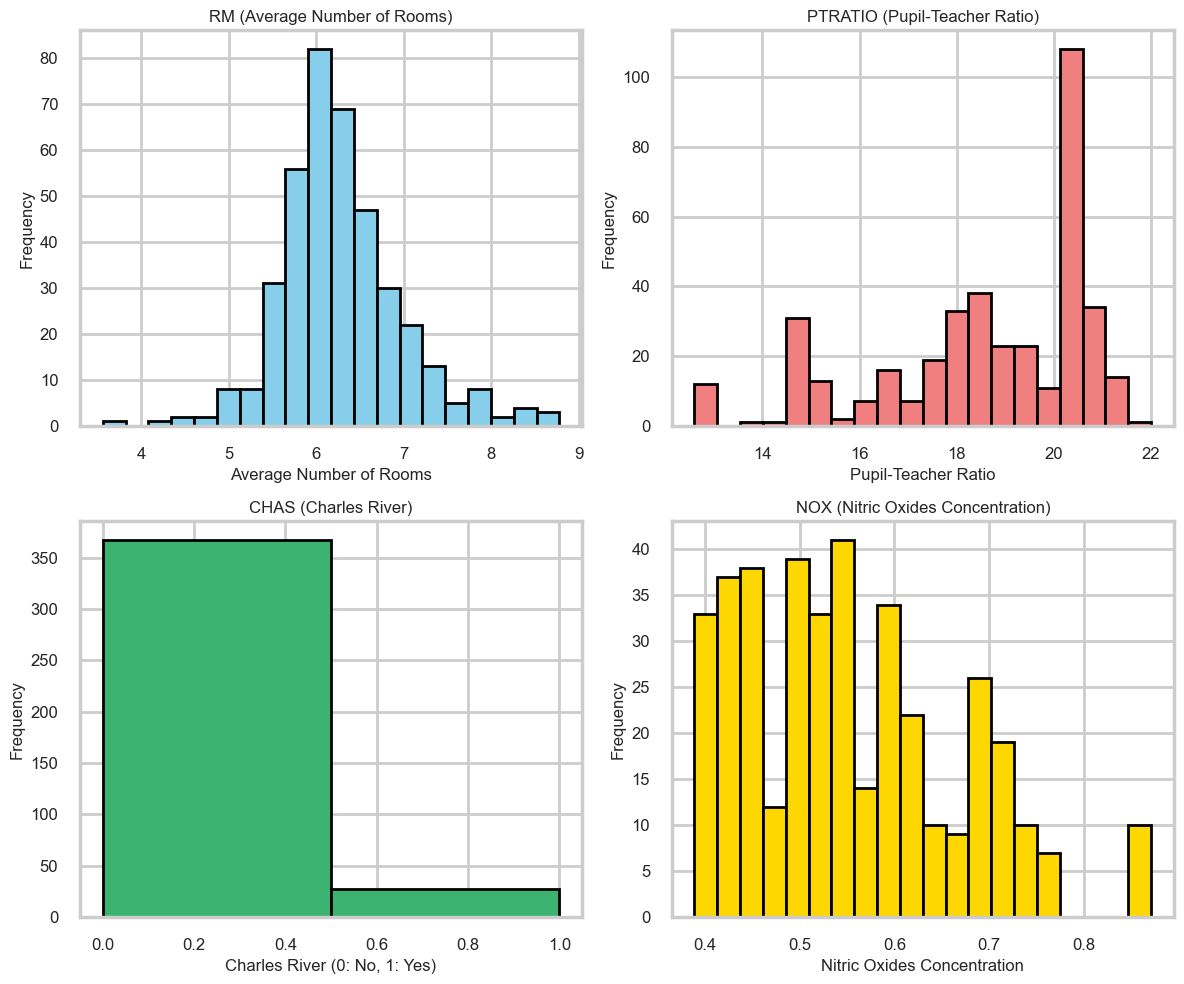

In [14]:
# Create a figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot histograms for RM, PTRATIO, CHAS, and NOX
axes[0, 0].hist(bos.RM, bins=20, color='skyblue', edgecolor='k')
axes[0, 0].set_title("RM (Average Number of Rooms)")
axes[0, 0].set_xlabel("Average Number of Rooms")
axes[0, 0].set_ylabel("Frequency")

axes[0, 1].hist(bos.PTRATIO, bins=20, color='lightcoral', edgecolor='k')
axes[0, 1].set_title("PTRATIO (Pupil-Teacher Ratio)")
axes[0, 1].set_xlabel("Pupil-Teacher Ratio")
axes[0, 1].set_ylabel("Frequency")

axes[1, 0].hist(bos.CHAS, bins=2, color='mediumseagreen', edgecolor='k')
axes[1, 0].set_title("CHAS (Charles River)")
axes[1, 0].set_xlabel("Charles River (0: No, 1: Yes)")
axes[1, 0].set_ylabel("Frequency")

axes[1, 1].hist(bos.NOX, bins=20, color='gold', edgecolor='k')
axes[1, 1].set_title("NOX (Nitric Oxides Concentration)")
axes[1, 1].set_xlabel("Nitric Oxides Concentration")
axes[1, 1].set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

## Part 3: Linear Regression with Boston Housing Data Example
***

Here, 

$Y$ = boston housing prices (called "target" data in python, and referred to as the dependent variable or response variable)

and

$X$ = all the other features (or independent variables, predictors or explanatory variables)

which we will use to fit a linear regression model and predict Boston housing prices. We will use the least-squares method to estimate the coefficients.  

We'll use two ways of fitting a linear regression. We recommend the first but the second is also powerful in its features.

### Fitting Linear Regression using `statsmodels`
***
[Statsmodels](http://statsmodels.sourceforge.net/) is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. While we don't cover statsmodels officially in the Data Science Intensive workshop, it's a good library to have in your toolbox. Here's a quick example of what you could do with it. The version of least-squares we will use in statsmodels is called *ordinary least-squares (OLS)*. There are many other versions of least-squares such as [partial least squares (PLS)](https://en.wikipedia.org/wiki/Partial_least_squares_regression) and [weighted least squares (WLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares).

In [15]:
# statsmodels works nicely with pandas dataframes
# The thing inside the "quotes" is called a formula, a bit on that below
m_rooms = ols('PRICE ~ RM',bos).fit()
print(m_rooms.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     431.7
Date:                Fri, 22 Sep 2023   Prob (F-statistic):           3.44e-65
Time:                        12:44:37   Log-Likelihood:                -1284.2
No. Observations:                 394   AIC:                             2572.
Df Residuals:                     392   BIC:                             2580.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -37.1944      2.884    -12.897      0.0

#### Interpreting coefficients

There is a ton of information in this output. But we'll concentrate on the coefficient table (middle table). We can interpret the `RM` coefficient (9.1021) by first noticing that the p-value (under `P>|t|`) is so small, basically zero. This means that the number of rooms, `RM`, is a statisticall significant predictor of `PRICE`. The regression coefficient for `RM` of 9.1021 means that *on average, each additional room is associated with an increase of $\$9,100$ in house price net of the other variables*. The confidence interval gives us a range of plausible values for this average change, about ($\$8,279, \$9,925$), definitely not chump change. 

In general, the $\hat{\beta_i}, i > 0$ can be interpreted as the following: "A one unit increase in $x_i$ is associated with, on average, a $\hat{\beta_i}$ increase/decrease in $y$ net of all other variables."

On the other hand, the interpretation for the intercept, $\hat{\beta}_0$ is the average of $y$ given that all of the independent variables $x_i$ are 0.

####  `statsmodels` formulas
***
This formula notation will seem familiar to `R` users, but will take some getting used to for people coming from other languages or are new to statistics.

The formula gives instruction for a general structure for a regression call. For `statsmodels` (`ols` or `logit`) calls you need to have a Pandas dataframe with column names that you will add to your formula. In the below example you need a pandas data frame that includes the columns named (`Outcome`, `X1`,`X2`, ...), but you don't need to build a new dataframe for every regression. Use the same dataframe with all these things in it. The structure is very simple:

`Outcome ~ X1`

But of course we want to to be able to handle more complex models, for example multiple regression is doone like this:

`Outcome ~ X1 + X2 + X3`

In general, a formula for an OLS multiple linear regression is

`Y ~ X1 + X2 + ... + Xp`

This is the very basic structure but it should be enough to get you through the homework. Things can get much more complex. You can force statsmodels to treat variables as categorical with the `C()` function, call numpy functions to transform data such as `np.log` for extremely-skewed data, or fit a model without an intercept by including `- 1` in the formula. For a quick run-down of further uses see the `statsmodels` [help page](http://statsmodels.sourceforge.net/devel/example_formulas.html).


Let's see how our model actually fit our data. We can see below that there is a ceiling effect, we should probably look into that. Also, for large values of $Y$ we get underpredictions, most predictions are below the 45-degree gridlines. 

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a scatterplot between the predicted prices, available in `m.fittedvalues` (where `m` is the fitted model) and the original prices. How does the plot look? Do you notice anything interesting or weird in the plot? Comment on what you see.</p>
</div>

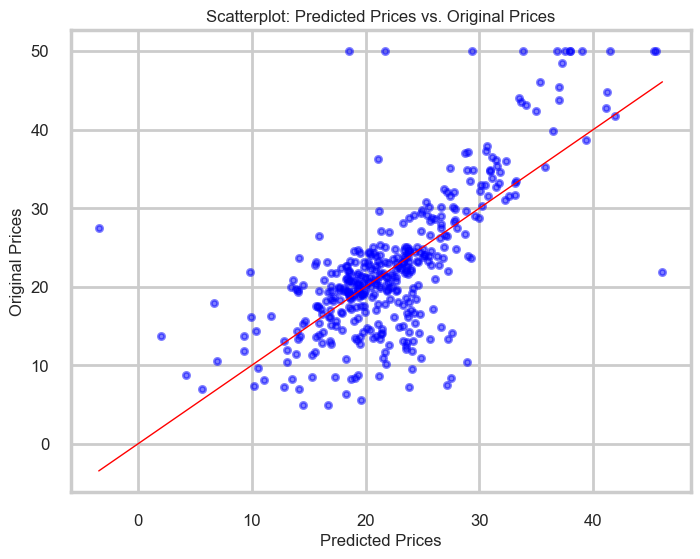

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(m_rooms.fittedvalues, bos.PRICE, s=20, alpha=0.5, color='blue')
plt.xlabel("Predicted Prices")
plt.ylabel("Original Prices")
plt.title("Scatterplot: Predicted Prices vs. Original Prices")

# Add a diagonal line for reference
plt.plot([min(m_rooms.fittedvalues), max(m_rooms.fittedvalues)], [min(m_rooms.fittedvalues), max(m_rooms.fittedvalues)], color='red', linewidth=1, linestyle='solid')

# Show the plot
plt.show()

**Positive Linear Relationship**: The scatterplot generally shows a positive linear relationship, which is a good sign. It suggests that the model's predictions are positively correlated with the actual housing prices, indicating that the model captures some of the underlying trends.

**Clustering of Points**: The majority of points cluster around the diagonal reference line (red solid line), indicating that the model's predictions are relatively close to the actual prices for many observations. This suggests that the model is performing reasonably well.

**Outliers**: However, there are a few noticeable outliers where the predicted prices significantly deviate from the actual prices. These outliers appear as points far away from the diagonal line. These instances may represent cases where the model struggled to accurately predict prices, potentially due to factors not captured by the single predictor variable ("RM").

**Heteroscedasticity**: There is some widening of the spread of points as we move from left to right along the x-axis. This suggests the presence of heteroscedasticity, which implies that the variance of errors may not be constant across all levels of predicted prices. This could be a concern for the model's reliability in certain price ranges.

### Fitting Linear Regression using `sklearn`


In [17]:
X = bos.drop('PRICE', axis = 1)

# This creates a LinearRegression object for all independent variables
lm = LinearRegression();

#### What can you do with a LinearRegression object? 
***
Check out the scikit-learn [docs here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). We have listed the main functions here. Most machine learning models in scikit-learn follow this same API of fitting a model with `fit`, making predictions with `predict` and the appropriate scoring function `score` for each model.

Main functions | Description
--- | --- 
`lm.fit()` | Fit a linear model
`lm.predict()` | Predict Y using the linear model with estimated coefficients
`lm.score()` | Returns the coefficient of determination (R^2). *A measure of how well observed outcomes are replicated by the model, as the proportion of total variation of outcomes explained by the model*

#### What output can you get?

In [18]:
# Look inside lm object
#lm.<tab>

Output | Description
--- | --- 
`lm.coef_` | Estimated coefficients
`lm.intercept_` | Estimated intercept 

### Fit a linear model
***

The `lm.fit()` function estimates the coefficients the linear regression using least squares. 

In [19]:
# Use all 13 predictors to fit linear regression model
lm.fit(X, bos.PRICE);

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> How would you change the model to not fit an intercept term? Would you recommend not having an intercept? Why or why not? For more information on why to include or exclude an intercept, look [here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-is-regression-through-the-origin/).</p>

<p><b>Exercise:</b> One of the assumptions of the linear model is that the residuals must be i.i.d. (independently and identically distributed). To satisfy this, is it enough that the residuals are normally distributed? Explain your answer.</p>

<p><b>Exercise:</b> True or false. To use linear regression, $Y$ must be normally distributed. Explain your answer.</p>
</div>


#### Exercise 1

#### How would you change the model to not fit an intercept term?

In [20]:
# Linear Regression model without intercept
lm_no_intercept = LinearRegression(fit_intercept=False)

# Use all 13 predictors to fit the linear regression model without an intercept
lm_no_intercept.fit(X, bos.PRICE);

#### Would you recommend not having an intercept? Yes or No.

No.  Including an intercept term is generally more realistic in the context of housing prices. It accounts for the fact that even when all predictor variables (e.g., number of rooms, pupil-teacher ratio) are at their minimum values, there may still be a baseline or fixed cost associated with housing.

**I should however recommend not having an intercept in the following situation:**
Suppose you have a dataset that records the time taken to cover a certain distance for a car traveling at a constant speed.  The physics of this situation dictates that when no time has passed (i.e., the car starts from rest), the distance covered should be zero. In this scenario, it makes sense to force the intercept to zero because it aligns with the physical principle.

#### Exercise 2

#### is it enough that the residuals are normally distributed? Yes or No.

No. Residuals that are normally distributed do not guarantee their independence and identical distribution.

#### Exercise 3

#### To use linear regression, $Y$ must be normally distributed. Yes or No.

No. Linear regression makes assumptions about the distribution of the residuals (errors), not the distribution of the response variable itself.

### Estimated intercept and coefficients

Let's look at the estimated coefficients from the linear model using `1m.intercept_` and `lm.coef_`.  

After we have fit our linear regression model using the least squares method, we want to see what are the estimates of our coefficients $\beta_0$, $\beta_1$, ..., $\beta_{13}$: 

$$ \hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_{13} $$



In [21]:
print('Estimated intercept coefficient: {}'.format(lm.intercept_))

Estimated intercept coefficient: 32.68005854330629


In [22]:
print('Number of coefficients: {}'.format(len(lm.coef_)))

Number of coefficients: 13


In [23]:
# The coefficients
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,CRIM,-0.097594
1,ZN,0.048905
2,INDUS,0.030379
3,CHAS,2.769378
4,NOX,-17.969028
5,RM,4.283252
6,AGE,-0.012991
7,DIS,-1.458510
8,RAD,0.285866
9,TAX,-0.013146


### Predict Prices 

We can calculate the predicted prices ($\hat{Y}_i$) using `lm.predict`. 

$$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_1 + \ldots \hat{\beta}_{13} X_{13} $$

In [24]:
# first five predicted prices
lm.predict(X)[0:5]

array([29.4365956 , 24.76875917, 30.39800878, 28.45203573, 24.88517936])

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Histogram: Plot a histogram of all the predicted prices. Write a story about what you see. Describe the shape, center and spread of the distribution. Are there any outliers? What might be the reason for them? Should we do anything special with them?</p>

<p><b>Exercise:</b> Scatterplot: Let's plot the true prices compared to the predicted prices to see they disagree (we did this with `statsmodels` before).</p>

<p><b>Exercise:</b> We have looked at fitting a linear model in both `statsmodels` and `scikit-learn`. What are the advantages and disadvantages of each based on your exploration? Based on the information provided by both packages, what advantage does `statsmodels` provide?</p>
</div>

#### Exercise 1 : Histogram

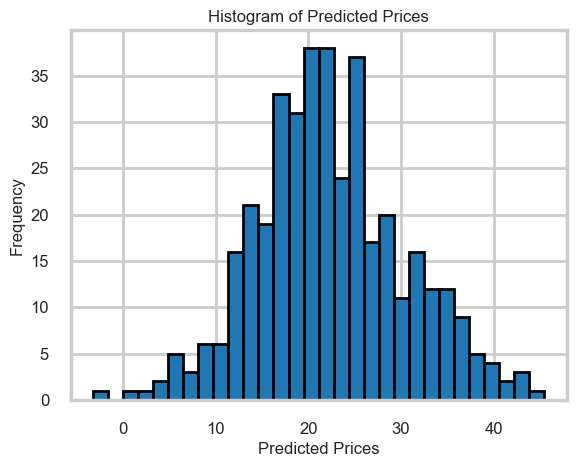

2.1313740231356615 42.226608227624425
Mean: 22.359644670050763
Max: 45.436122219137616
Outliers: [42.60027313537621, 43.76636680617285, 43.28167137608477, 45.436122219137616, 1.5646550517998534, -3.2326795360133005]


In [25]:
def get_outliers(data): 
    # using the Interquartile Range IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    # Calculate the IQR
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(lower_bound, upper_bound)
    # Identify outliers
    outliers = [x for x in y_pred if x < lower_bound or x > upper_bound]
    return outliers

y_pred = lm.predict(X)

# Create a histogram
plt.hist(y_pred, bins=30, edgecolor='k')
plt.xlabel("Predicted Prices")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Prices")
plt.show()
mean = y_pred.mean()
maxprice = y_pred.max()
outliers = get_outliers(y_pred)
print("Mean:", mean)
print("Max:", maxprice)
print("Outliers:", outliers)

The distribution of the data resembles a roughly bell-shaped curve, suggesting it follows a normal distribution. It's symmetric, with a peak around a value near 20.   The center or mean of the distribution is approximately 20, which indicates that this is the average value in the predicted prices.  The data has a moderate level of spread, ranging from around 0 to 45. This means there is variability in the data, with values deviating from the center.  Yes, there are outliers in this data based on the Interquartile Range method. The boundaries are 2.45 and 42.35 and I found six outliers.  Low (or negative) predicted prices are definitely not realistic in this dataset.  The higher values are to be investigated further.

#### Exercise 2: Scatterplot

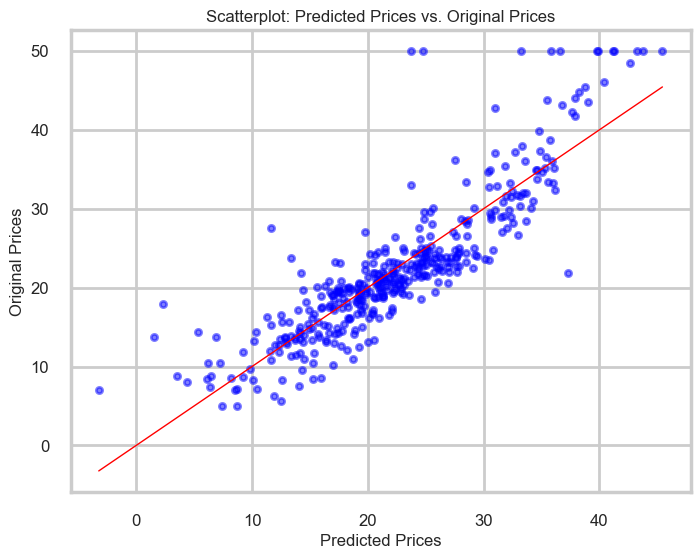

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, bos.PRICE, s=20, alpha=0.5, color='blue')
plt.xlabel("Predicted Prices")
plt.ylabel("Original Prices")
plt.title("Scatterplot: Predicted Prices vs. Original Prices")

# Add a diagonal line for reference
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], color='red', linewidth=1, linestyle='solid')

# Show the plot
plt.show()

#### Exercise 3 : statmodel vs scikit-learn

statsmodels:
- \+ provides detailed statistical summary information
- \+ summary output is highly detailed
- \- contains R-like formula syntax (I prefer Python syntax)

scikit-learn:
- \+ is used for various machine learning algorithms including linear regression
- \+ has a large user community and extensive documentation
- \- does not extensive statistical information

### Evaluating the Model: Sum-of-Squares

The partitioning of the sum-of-squares shows the variance in the predictions explained by the model and the variance that is attributed to error.

$$TSS = ESS + RSS$$

#### Residual Sum-of-Squares (aka $RSS$)

The residual sum-of-squares is one of the basic ways of quantifying how much error exists in the fitted model. We will revisit this in a bit.

$$ RSS = \sum_{i=1}^N r_i^2 = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

In [27]:
print(np.sum((bos.PRICE - lm.predict(X)) ** 2))

7650.848784709555


#### Explained Sum-of-Squares (aka $ESS$)

The explained sum-of-squares measures the variance explained by the regression model.

$$ESS = \sum_{i=1}^N \left( \hat{y}_i - \bar{y} \right)^2 = \sum_{i=1}^N \left( \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) - \bar{y} \right)^2$$

In [28]:
print(np.sum((lm.predict(X) - np.mean(bos.PRICE))**2))

25201.619565544148


### Evaluating the Model: The Coefficient of Determination ($R^2$)

The coefficient of determination, $R^2$, tells us the percentage of the variance in the response variable $Y$ that can be explained by the linear regression model.

$$ R^2 = \frac{ESS}{TSS} $$

The $R^2$ value is one of the most common metrics that people use in describing the quality of a model, but it is important to note that *$R^2$ increases artificially as a side-effect of increasing the number of independent variables.* While $R^2$ is reported in almost all statistical packages, another metric called the *adjusted $R^2$* is also provided as it takes into account the number of variables in the model, and can sometimes even be used for non-linear regression models!

$$R_{adj}^2 = 1 - \left( 1 - R^2 \right) \frac{N - 1}{N - K - 1} = R^2 - \left( 1 - R^2 \right) \frac{K}{N - K - 1} = 1 - \frac{\frac{RSS}{DF_R}}{\frac{TSS}{DF_T}}$$

where $N$ is the number of observations, $K$ is the number of variables, $DF_R = N - K - 1$ is the degrees of freedom associated with the residual error and $DF_T = N - 1$ is the degrees of the freedom of the total error.

### Evaluating the Model: Mean Squared Error and the $F$-Statistic
***
The mean squared errors are just the *averages* of the sum-of-squares errors over their respective degrees of freedom.

$$MSR = \frac{ESS}{K}$$

$$MSE = \frac{RSS}{N-K-1}$$

**Remember:** Notation may vary across resources particularly the use of *R* and *E* in *RSS/ESS* and *MSR/MSE*. In some resources, E = explained and R = residual. In other resources, E = error and R = regression (explained). **This is a very important distinction that requires looking at the formula to determine which naming scheme is being used.**

Given the MSR and MSE, we can now determine whether or not the entire model we just fit is even statistically significant. We use an $F$-test for this. The null hypothesis is that all of the $\beta$ coefficients are zero, that is, none of them have any effect on $Y$. The alternative is that *at least one* $\beta$ coefficient is nonzero, but it doesn't tell us which one in a multiple regression:

$$H_0: \beta_i = 0, \mbox{for all $i$} \\
H_A: \beta_i > 0, \mbox{for some $i$}$$ 

$$F = \frac{MSR}{MSE} = \left( \frac{R^2}{1 - R^2} \right) \left( \frac{N - K - 1}{K} \right)$$
 
Once we compute the $F$-statistic, we can use the $F$-distribution with $N-K$ and $K-1$ degrees of degrees of freedom to get a p-value.

**Warning!** The $F$-statistic mentioned in this section is NOT the same as the F1-measure or F1-value discused in Unit 7.

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set IV</h3>

<p>Let's look at the relationship between `PTRATIO` and housing price.</p>

<p><b>Exercise:</b> Try fitting a linear regression model using only the 'PTRATIO' (pupil-teacher ratio by town) and interpret the intercept and the coefficients.</p>

<p><b>Exercise:</b> Calculate (or extract) the $R^2$ value. What does it tell you?</p>

<p><b>Exercise:</b> Compute the $F$-statistic. What does it tell you?</p>

<p><b>Exercise:</b> Take a close look at the $F$-statistic and the $t$-statistic for the regression coefficient. What relationship do you notice? Note that this relationship only applies in *simple* linear regression models.</p>
</div>

#### Exercise 1: interpret the intercept and coefficient

In [29]:
m_ptratio = ols('PRICE ~ PTRATIO',bos).fit()
print(m_ptratio.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     164.6
Date:                Fri, 22 Sep 2023   Prob (F-statistic):           1.06e-31
Time:                        12:45:20   Log-Likelihood:                -1361.4
No. Observations:                 394   AIC:                             2727.
Df Residuals:                     392   BIC:                             2735.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.9034      3.339     19.441      0.0

The intercept represents the estimated housing price (62344$) when 'PTRATIO' is zero (which may not have a meaningful interpretation in this context).  The coefficient for 'PTRATIO' (-2.15) represents the change in housing price for a one-unit change in 'PTRATIO'.  The negative sign of the coefficient indicates that the house price drops if the PTRATIO goes up, and its magnitude indicates the strength of the relationship which is low strength.  As a comparison: the coefficient for the NOX feature is -33.91 which indicates a much stronger relationship. 

#### Exercise 2: Calculate (or extract) the  𝑅2 value. What does it tell you?

In [30]:
print("R-squared:", m_ptratio.rsquared)

R-squared: 0.2957282434686058


The 𝑅² value is close to 0 and this indicates that 'PTRATIO' only explains around 25% of the variance in 'PRICE' and the model may not be a good fit for the data. So the 'PTRATIO' is not a good predictor of housing prices in this model.

#### Exercise 3: Compute the  𝐹 -statistic. What does it tell you?

In [31]:
# Calculate the F-statistic
print("F-statistic:", m_ptratio.fvalue)

F-statistic: 164.60332302780037


In [35]:
import pandas as pd

# Get the coefficient and standard error of PTRATIO
coefficient_value = m_ptratio.params['PTRATIO']
standard_error = m_ptratio.bse['PTRATIO']
r_squared = m_ptratio.rsquared

# Extract t-statistic and p-value for 'PTRATIO'
t_statistic = m_ptratio.tvalues['PTRATIO']
p_value = m_ptratio.pvalues['PTRATIO']

# Create a DataFrame to display the results in a table format
results_df = pd.DataFrame({
    'Parameter': ['PTRATIO'],
    'Coefficient': [coefficient_value],
    'Standard Error': [standard_error],
    't-statistic': [t_statistic],
    'P-value': [p_value],
    'R-squared': [r_squared]
})

# Print the results in a table format
print(results_df)

  Parameter  Coefficient  Standard Error  t-statistic       P-value  R-squared
0   PTRATIO    -2.295004        0.178881   -12.829783  1.057013e-31   0.295728


The combination of a large F-statistic and an extremely small p-value strongly suggests that the regression model is highly statistically significant. This means that the PTRATIO has a significant effect on the house price.  However, the relatively low R-squared value suggests that while the model is statistically significant, there are other factors beyond PTRATIO that influence housing prices.

#### Exercise 4: Relationship between 𝐹 -statistic and the 𝑡-statistic

The square of the t-statistic for a specific coefficient is equal to the F-statistic for testing the significance of PTRATIO coefficient alone.

$$ t = \frac{\text{Estimated coefficient}}{\text{Standard Error of coefficient}} = \frac{\hat{\beta}_1}{SE(\hat{\beta}_1)} = \frac{-2.2950}{0.1788} \approx -12.8297 $$

$$ t^2 \approx F \approx 164.6033 $$

<div class="span5 alert alert-info">
<h3>Part 3 Checkup Exercise Set V</h3>

<p>Fit a linear regression model using three independent variables</p>

<ol>
<li> 'CRIM' (per capita crime rate by town)
<li> 'RM' (average number of rooms per dwelling)
<li> 'PTRATIO' (pupil-teacher ratio by town)
</ol>

<p><b>Exercise:</b> Compute or extract the $F$-statistic. What does it tell you about the model?</p>

<p><b>Exercise:</b> Compute or extract the $R^2$ statistic. What does it tell you about the model?</p>

<p><b>Exercise:</b> Which variables in the model are significant in predicting house price? Write a story that interprets the coefficients.</p>
</div>

#### Exercise 1: Fit a linear model using three independent variables

In [36]:
X = sm.add_constant(bos[['CRIM', 'RM', 'PTRATIO']])
m_3_features = sm.OLS(bos['PRICE'], X).fit()

# Print the model summary
print(m_3_features.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     230.5
Date:                Fri, 22 Sep 2023   Prob (F-statistic):           5.34e-86
Time:                        12:47:34   Log-Likelihood:                -1229.6
No. Observations:                 394   AIC:                             2467.
Df Residuals:                     390   BIC:                             2483.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3310      4.430     -0.752      0.4

#### Exercise 2: Compute or extract the  𝐹-statistic. What does it tell you about the model?

In [37]:
m_3_features.fvalue

230.48696590157414

We also have to take the p-value into account.  Here, the p-value is very close to zero.  This means that **at least one** of the independent variables has a significant effect on the dependent variable.  This model as a whole with three independent variables (CRIM, RM, PTRATIO) does a better job of explaining the variation in house prices than the model with just one independent variable (PTRATIO).  The F-statistic of 230 is larger than the previous on 164.

#### Exercise 3: Compute or extract the  𝑅2 statistic. What does it tell you about the model?

In [38]:
m_3_features.rsquared

0.639376697920627

This value indicates that these three variables together explain approximately 63.9% of the variance in house prices.

#### Exercise 4: Which variables in the model are significant in predicting house price? Write a story that interprets the coefficients.

The significance of the variables can be determined by examining their coefficients and associated p-values.

1. **CRIM (Crime Rate):** The coefficient for 'CRIM' is approximately -0.1944, and the p-value is very close to zero (p < 0.001). This indicates that 'CRIM' is a statistically significant predictor of house prices. A negative coefficient suggests that as the crime rate increases, the house price tends to decrease.

2. **RM (Number of Rooms):** The coefficient for 'RM' is approximately 7.5335, and the p-value is very close to zero (p < 0.001). This indicates that 'RM' is a highly significant predictor of house prices. A positive coefficient suggests that as the average number of rooms in a dwelling increases, the house price tends to increase.

3. **PTRATIO (Pupil-Teacher Ratio):** The coefficient for 'PTRATIO' is approximately -1.1276, and the p-value is very close to zero (p < 0.001). This indicates that 'PTRATIO' is also a highly significant predictor of house prices. A negative coefficient suggests that as the pupil-teacher ratio increases (indicating fewer teachers per pupil), the house price tends to decrease.

'RM' has the largest positive effect. The model's R-squared value of 0.639 indicates that these three variables together explain approximately 63.9% of the variance in house prices.

## Part 4: Comparing Models

During modeling, there will be times when we want to compare models to see which one is more predictive or fits the data better. There are many ways to compare models, but we will focus on two.

### The $F$-Statistic Revisited

The $F$-statistic can also be used to compare two *nested* models, that is, two models trained on the same dataset where one of the models contains a *subset* of the variables of the other model. The *full* model contains $K$ variables and the *reduced* model contains a subset of these $K$ variables. This allows us to add additional variables to a base model and then test if adding the variables helped the model fit.

$$F = \frac{\left( \frac{RSS_{reduced} - RSS_{full}}{DF_{reduced} - DF_{full}} \right)}{\left( \frac{RSS_{full}}{DF_{full}} \right)}$$

where $DF_x = N - K_x - 1$ where $K_x$ is the number of variables in model $x$.

### Akaike Information Criterion (AIC)

Another statistic for comparing two models is AIC, which is based on the likelihood function and takes into account the number of variables in the model.

$$AIC = 2 K - 2 \log_e{L}$$

where $L$ is the likelihood of the model. AIC is meaningless in the absolute sense, and is only meaningful when compared to AIC values from other models. Lower values of AIC indicate better fitting models.

`statsmodels` provides the AIC in its output.

<div class="span5 alert alert-info">
<h3>Part 4 Checkup Exercises</h3>

<p><b>Exercise:</b> Find another variable (or two) to add to the model we built in Part 3. Compute the $F$-test comparing the two models as well as the AIC. Which model is better?</p>
</div>

In [40]:
independent_variables = ['CRIM', 'RM', 'PTRATIO', 'NOX', 'CHAS']
X = sm.add_constant(bos[independent_variables])
m_5_features = sm.OLS(bos['PRICE'], X).fit()
print(m_5_features.summary())
print("\nF-statistic:", m_5_features.fvalue)
#print("P-values:",m_5_features.pvalues[independent_variables])
print("\nP-values:")
print(pd.Series(m_5_features.pvalues[independent_variables]).to_string(index=False)) # trick to remove the dtype output line
print("\nAIC:", m_5_features.aic)

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     161.4
Date:                Fri, 22 Sep 2023   Prob (F-statistic):           1.96e-92
Time:                        12:48:33   Log-Likelihood:                -1208.9
No. Observations:                 394   AIC:                             2430.
Df Residuals:                     388   BIC:                             2454.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0322      4.653      1.726      0.0

 The model with the lowest AIC is considered the best. 
 So the last model (with 5 independent variables : 'CRIM', 'RM', 'PTRATIO', 'NOX', 'CHAS' ) is better (AIC = 2430) than the previous model (with 3 independent variables: 'CRIM', 'RM', 'PTRATIO') (AIC = 2467)


## Part 5: Evaluating the Model via Model Assumptions and Other Issues
***
Linear regression makes several assumptions. It is always best to check that these assumptions are valid after fitting a linear regression model.

<div class="span5 alert alert-danger">
<ul>
  <li>**Linearity**. The dependent variable $Y$ is a linear combination of the regression coefficients and the independent variables $X$. This can be verified with a scatterplot of each $X$ vs. $Y$ and plotting correlations among $X$. Nonlinearity can sometimes be resolved by [transforming](https://onlinecourses.science.psu.edu/stat501/node/318) one or more independent variables, the dependent variable, or both. In other cases, a [generalized linear model](https://en.wikipedia.org/wiki/Generalized_linear_model) or a [nonlinear model](https://en.wikipedia.org/wiki/Nonlinear_regression) may be warranted.</li>
  <li>**Constant standard deviation**. The SD of the dependent variable $Y$ should be constant for different values of X. We can check this by plotting each $X$ against $Y$ and verifying that there is no "funnel" shape showing data points fanning out as $X$ increases or decreases. Some techniques for dealing with non-constant variance include weighted least squares (WLS), [robust standard errors](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors), or variance stabilizing transformations.
    </li>
  <li> **Normal distribution for errors**.  The $\epsilon$ term we discussed at the beginning are assumed to be normally distributed. This can be verified with a fitted values vs. residuals plot and verifying that there is no pattern, and with a quantile plot.
  $$ \epsilon_i \sim N(0, \sigma^2)$$
Sometimes the distributions of responses $Y$ may not be normally distributed at any given value of $X$.  e.g. skewed positively or negatively. </li>
<li> **Independent errors**.  The observations are assumed to be obtained independently.
    <ul>
        <li>e.g. Observations across time may be correlated
    </ul>
</li>
</ul>  

</div>

There are some other issues that are important investigate with linear regression models.

<div class="span5 alert alert-danger">
<ul>
  <li>**Correlated Predictors:** Care should be taken to make sure that the independent variables in a regression model are not too highly correlated. Correlated predictors typically do not majorly affect prediction, but do inflate standard errors of coefficients making interpretation unreliable. Common solutions are dropping the least important variables involved in the correlations, using regularlization, or, when many predictors are highly correlated, considering a dimension reduction technique such as principal component analysis (PCA).
  <li>**Influential Points:** Data points that have undue influence on the regression model. These points can be high leverage points or outliers. Such points are typically removed and the regression model rerun.
</ul>
</div>


<div class="span5 alert alert-info">
<h3>Part 5 Checkup Exercises</h3>

<p>Take the reduced model from Part 3 to answer the following exercises. Take a look at [this blog post](http://mpastell.com/2013/04/19/python_regression/) for more information on using statsmodels to construct these plots.</p>
    
<p><b>Exercise:</b> Construct a fitted values versus residuals plot. What does the plot tell you? Are there any violations of the model assumptions?</p>

<p><b>Exercise:</b> Construct a quantile plot of the residuals. What does the plot tell you?</p>

<p><b>Exercise:</b> What are some advantages and disadvantages of the fitted vs. residual and quantile plot compared to each other?</p>

<p><b>Exercise:</b> Identify any outliers (if any) in your model and write a story describing what these outliers might represent.</p>

<p><b>Exercise:</b> Construct a leverage plot and identify high leverage points in the model. Write a story explaining possible reasons for the high leverage points.</p>

<p><b>Exercise:</b> Remove the outliers and high leverage points from your model and run the regression again. How do the results change?</p>
</div>

#### Exercise 1: fitted values versus residuals plot

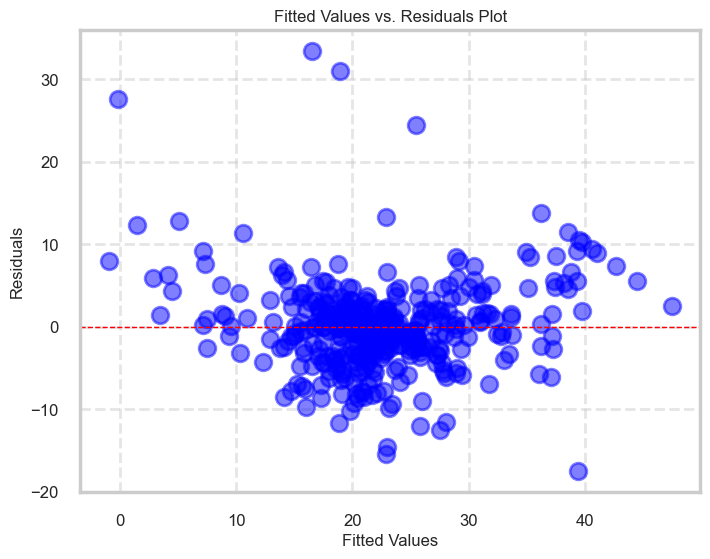

In [42]:
# Get the fitted values and residuals
fitted_values = m_3_features.fittedvalues
residuals = m_3_features.resid

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals, c='b', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted Values vs. Residuals Plot")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

The main purpose of this plot is to assess the **linearity** assumption.  This is not exactly the case.  I see some clustering in the middle of the plot so the **linearity** assumption may be violated.  The clustering could also be an indication of issues with **independence**.
The spread of the residuals indicate heteroscedasticity, which violates the assumption of **homoscedasticity (constant variance)**.  I see four individual data points with high value residuals above the 20-line.  These could be outliers.

#### Exercise 2: quantile plot of the residuals

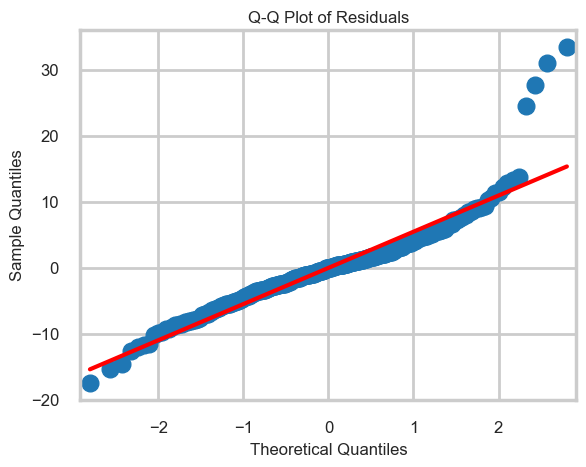

In [43]:
# Calculate the residuals
residuals = m_3_features.resid

# Create a Q-Q plot
sm.qqplot(residuals, line='s')  # 's' for standard normal distribution
plt.title("Q-Q Plot of Residuals")
plt.show()

The Q-Q plot tells me if the residuals are normally distributed.
The residuals closely follow the straight diagonal line, so it suggests that the residuals are normally distributed.

#### Exercise 3: advantages and disadvantages of the fitted vs. residual and quantile plot

**Advantages of the fitted plot:**

- A fitted plot can help me to assess the linearity assumption.
- Patterns in the spread of residuals can reveal heteroscedasticity.
- It is easier to visually identify outliers.

**Disadvantages of the fitted plot:**

- The fitted plot is not suitable for assessing normality.

**Advantages of the quantile plot:**

- Quantile plots can help me to assess a normal distribution.

**Disadvantages of the quantile plot:**

- Q-Q plots can not help me to assess the linearity assumption or the presence of heteroscedasticity.

#### Exercise 4: Outliers

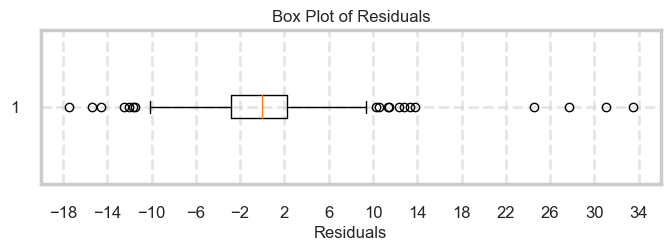

In [44]:
# Get the residuals from the model
residuals = m_3_features.resid

# Create a box plot for the residuals
plt.figure(figsize=(8, 2))
plt.boxplot(residuals, vert=False)
plt.xlabel("Residuals")
plt.title("Box Plot of Residuals")
plt.grid(True, linestyle='--', alpha=0.5)
#X-tick stepsize
stepsize = 4 
custom_xticks = np.arange(np.floor(min(residuals)), np.ceil(max(residuals)) + 1, stepsize)
plt.xticks(custom_xticks)
plt.show()

In [45]:
# Create a mask for outliers based on the threshold
outlier_mask_gt_20 = residuals > 20
outlier_mask_lt_10 = residuals < -14

# Use the mask to filter rows in the 'bos' DataFrame
outlier_rows = bos[outlier_mask_gt_20 | outlier_mask_lt_10]

# Display the outlier rows
outlier_rows.sort_values(by='PRICE', ascending=True)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
416,10.83420,0.0,18.1,0.0,0.679,6.782,90.8,1.8195,24,666,20.2,21.57,25.79,7.5
419,11.81230,0.0,18.1,0.0,0.718,6.824,76.5,1.7940,24,666,20.2,48.45,22.74,8.4
364,3.47428,0.0,18.1,1.0,0.718,8.780,82.9,1.9047,24,666,20.2,354.55,5.29,21.9
365,4.55587,0.0,18.1,0.0,0.718,3.561,87.9,1.6132,24,666,20.2,354.70,7.12,27.5
370,6.53876,0.0,18.1,1.0,0.631,7.016,97.5,1.2024,24,666,20.2,392.05,2.96,50.0
371,9.23230,0.0,18.1,0.0,0.631,6.216,100.0,1.1691,24,666,20.2,366.15,9.53,50.0
372,8.26725,0.0,18.1,1.0,0.668,5.875,89.6,1.1296,24,666,20.2,347.88,8.88,50.0


According to my outlier analysis, the AGE could be the cause of the outliers having an extreme low or an extreme high house price.  The real estate market often values older properties differently based on location and demand. In some cases, older properties in desirable neighborhoods can have higher prices due to their historical charm, while those in less desirable areas may have lower prices due to maintenance needs.

#### Exercise 5: leverage plot

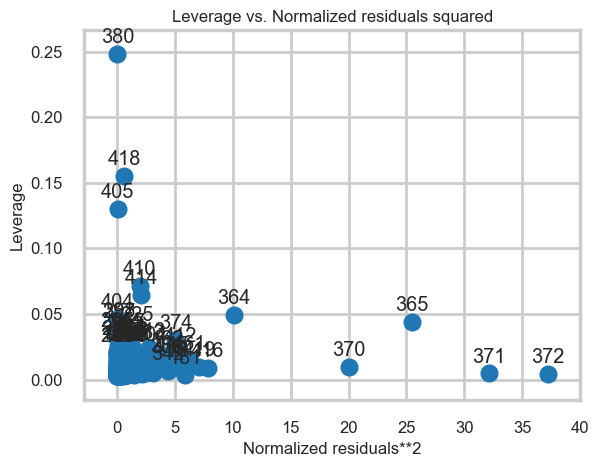

In [46]:
# Create a leverage plot
leverage_plot = plot_leverage_resid2(m_3_features)

High leverage points often occur when a data point has extreme values for one or more predictors. As stated in my previous outlier analysis, the AGE of the property could be a valid reason.  Errors in data collection could also be a reason for the high leverage points.  Further investigation of these points could improve the model's performance.

#### Exercise 6: remove outliers and refit the model

In [47]:
# Create a dataset without outliers
bos_without_outliers = bos[~bos.index.isin(outlier_rows.index)]

# Refit the linear regression model using the dataset without outliers
X_without_outliers = sm.add_constant(bos_without_outliers[['CRIM', 'RM', 'PTRATIO']])
m_3_features_without_outliers = sm.OLS(bos_without_outliers['PRICE'], X_without_outliers).fit()

# Print the summary
print(m_3_features_without_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     383.0
Date:                Fri, 22 Sep 2023   Prob (F-statistic):          6.79e-115
Time:                        12:52:09   Log-Likelihood:                -1123.4
No. Observations:                 387   AIC:                             2255.
Df Residuals:                     383   BIC:                             2271.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.2265      3.712     -2.486      0.0

**Comparison between the summaries of models with and without outliers**

| Metric                  | With Outliers | Without Outliers |
|-------------------------|---------------|------------------|
| R-squared               | 0.639         | 0.750            |
| F-statistic             | 230.5         | 383.0            |
| AIC                     | 2467.0        | 2255.0           |

This table provides a clear side-by-side comparison of the important metrics for the models with and without outliers, highlighting the differences in their performance.

The model without outliers shows higher performance across several key aspects. Firstly, its R² value is notably higher (0.750 compared to 0.639), indicating a more effective fit to the data. Additionally, the higher F-statistic suggests increased statistical significance, reinforcing the model's reliability. Moreover, the lower AIC value in the outlier-free model signifies an enhanced fit overall. In summary, the removal of outliers has had a positive impact on the model's overall performance and statistical validity.